In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

In [2]:
res = gpd.read_file(r'../../Data/processed/manhattan_residential.geojson')

In [3]:
manhattan = gpd.read_file(r'../../Data/processed/manhattan_buildings.geojson')

In [4]:
res.columns

Index(['base_bbl', 'construction_year', 'height_roof', 'bin', 'CURTAXCLASS',
       'CURMKTTOT', 'PYMKTTOT', 'GROSS_SQFT', 'RESIDENTIAL_AREA_GROSS',
       'BLD_STORY', 'ZONING', 'BLDG_CLASS', 'price_per_sqft',
       'price_per_sqft_2024', 'time_taken', 'elevator', 'unitsres',
       'res_share', 'elevator_flag', 'price_inc', 'geometry'],
      dtype='object')

In [5]:
# clustering 1
K = 5
RANDOM_STATE = 42

In [6]:
def kmeans_and_profile_fast(df, k=6, random_state=42, weights=None, stats=("min","median","mean","max")):
    feat_cols = [
        "height_roof",
        "BLD_STORY",
        'elevator_flag',
        "RESIDENTIAL_AREA_GROSS",
        "res_share",
    ]
    
    weights = np.array([
        1,   # height_roof
        3,   # BLD_STORY
        3,   # elevator
        2,   # RESIDENTIAL_AREA_GROSS
        2,   # res_share
    ], dtype=np.float32)

    df[feat_cols] = (
        df[feat_cols]
        .apply(pd.to_numeric, errors="coerce")
        .replace([np.inf, -np.inf], np.nan)
        .astype(np.float32)
    )
    X = df[feat_cols].to_numpy(dtype=np.float32)

    imp = SimpleImputer(strategy="median")
    X_imp = imp.fit_transform(X).astype(np.float32)

    q01 = np.nanpercentile(X_imp, 1, axis=0)
    q99 = np.nanpercentile(X_imp, 99, axis=0)
    X_clip = np.clip(X_imp, q01, q99).astype(np.float32)

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_clip).astype(np.float32)

    X_w = (X_scaled * weights).astype(np.float32)

    km = KMeans(n_clusters=k, n_init=10, algorithm="elkan", random_state=random_state)
    labels = km.fit_predict(X_w)

    # --- Stable relabeling by mean height_roof ---
    label_order = (
        pd.DataFrame({"label": labels, "height_roof": df["height_roof"]})
        .groupby("label")["height_roof"]
        .mean()
        .sort_values()
        .index
        .tolist()
    )
    remap = {old: new for new, old in enumerate(label_order)}
    labels = np.array([remap[l] for l in labels], dtype=np.int32)

    df = df.assign(kmeans_label=labels)

    all_df = km.transform(X_w).astype(np.float32)
    chosen_df = all_df[np.arange(all_df.shape[0]), km.labels_]
    r90 = {c: np.nanpercentile(chosen_df[labels == c], 90) for c in range(k)}
    r95 = {c: np.nanpercentile(chosen_df[labels == c], 95) for c in range(k)}
    conf = 1.0 - np.minimum(
        chosen_df / np.array([r90[c] for c in labels], dtype=np.float32),
        1.0
    )
    df = df.assign(cluster_confidence=conf.astype(np.float32))

    X_clip_df = pd.DataFrame(X_clip, columns=feat_cols, index=df.index)
    X_clip_df["kmeans_label"] = labels
    agg = {c: list(stats) for c in feat_cols}
    prof = X_clip_df.groupby("kmeans_label").agg(agg)
    prof[("n","count")] = X_clip_df.groupby("kmeans_label").size()
    cols = [("n","count")] + [c for c in prof.columns if c != ("n","count")]
    prof = prof.reindex(columns=cols)

    return {
        "data": df,
        "model": km,
        "scaler": scaler,
        "imputer": imp,
        "feature_weights": dict(zip(feat_cols, weights.tolist())),
        "cluster_profile": prof,
        "r90": r90,
        "r95": r95,
    }


In [7]:
results = kmeans_and_profile_fast(res, k=K, random_state=RANDOM_STATE)
manhattan_k = results["data"]
profile = results["cluster_profile"]

In [8]:
print(profile["height_roof"])

                    min      median        mean         max
kmeans_label                                               
0             14.150562   55.799999   53.352913  146.660004
1             14.150562   70.879997   76.811020  383.000000
2             14.150562  145.500000  140.807602  385.000000
3             14.150562  198.979996  200.199066  387.000000
4             14.150562  339.758240  323.183136  390.000000


In [9]:
print(profile["BLD_STORY"])

               min  median       mean   max
kmeans_label                               
0              2.0     5.0   4.428088   7.0
1              2.0     6.0   6.400766  12.0
2              8.0    14.0  13.997537  19.0
3             16.0    21.0  21.666140  30.0
4             27.0    34.0  34.147610  38.0


In [10]:
print(profile["elevator_flag"])

              min  median      mean  max
kmeans_label                            
0             0.0     0.0  0.020502  1.0
1             0.0     1.0  0.952730  1.0
2             0.0     1.0  0.882389  1.0
3             0.0     1.0  0.881435  1.0
4             0.0     1.0  0.912777  1.0


In [11]:
print(profile["RESIDENTIAL_AREA_GROSS"])

              min       median          mean        max
kmeans_label                                           
0             0.0   750.000000    868.268860   9174.000
1             0.0  2657.250000   3390.990479  24246.875
2             0.0  6201.875000   7352.059082  24246.875
3             0.0  8637.562500  10620.717773  24246.875
4             0.0  7400.674805   9597.305664  24246.875


In [12]:
print(profile["res_share"])

              min    median      mean  max
kmeans_label                              
0             0.0  0.811676  0.556490  1.0
1             0.0  1.000000  0.885260  1.0
2             0.0  0.970906  0.933560  1.0
3             0.0  0.944325  0.901473  1.0
4             0.0  0.896487  0.835654  1.0


In [13]:
cluster_names = {
    0: "Small Walk-Up Lowrise",
    1: "Elevator Lowrise",
    2: "Midrise Residential",
    3: "Large Highrise Residential",
    4: "Narrow Residential Towers"
}

# Apply mapping to your dataframe
results["data"]["cluster_name"] = results["data"]["kmeans_label"].map(cluster_names)

# Also add to profile for easier readability
profile_named = results["cluster_profile"].copy()
profile_named.index = profile_named.index.map(cluster_names)

In [14]:
res_socio = results['data']
res_socio.columns

Index(['base_bbl', 'construction_year', 'height_roof', 'bin', 'CURTAXCLASS',
       'CURMKTTOT', 'PYMKTTOT', 'GROSS_SQFT', 'RESIDENTIAL_AREA_GROSS',
       'BLD_STORY', 'ZONING', 'BLDG_CLASS', 'price_per_sqft',
       'price_per_sqft_2024', 'time_taken', 'elevator', 'unitsres',
       'res_share', 'elevator_flag', 'price_inc', 'geometry', 'kmeans_label',
       'cluster_confidence', 'cluster_name'],
      dtype='object')

In [15]:
res_socio['cluster_name'].value_counts()

cluster_name
Small Walk-Up Lowrise         124524
Elevator Lowrise               41760
Midrise Residential            24360
Large Highrise Residential     10121
Narrow Residential Towers       6856
Name: count, dtype: int64

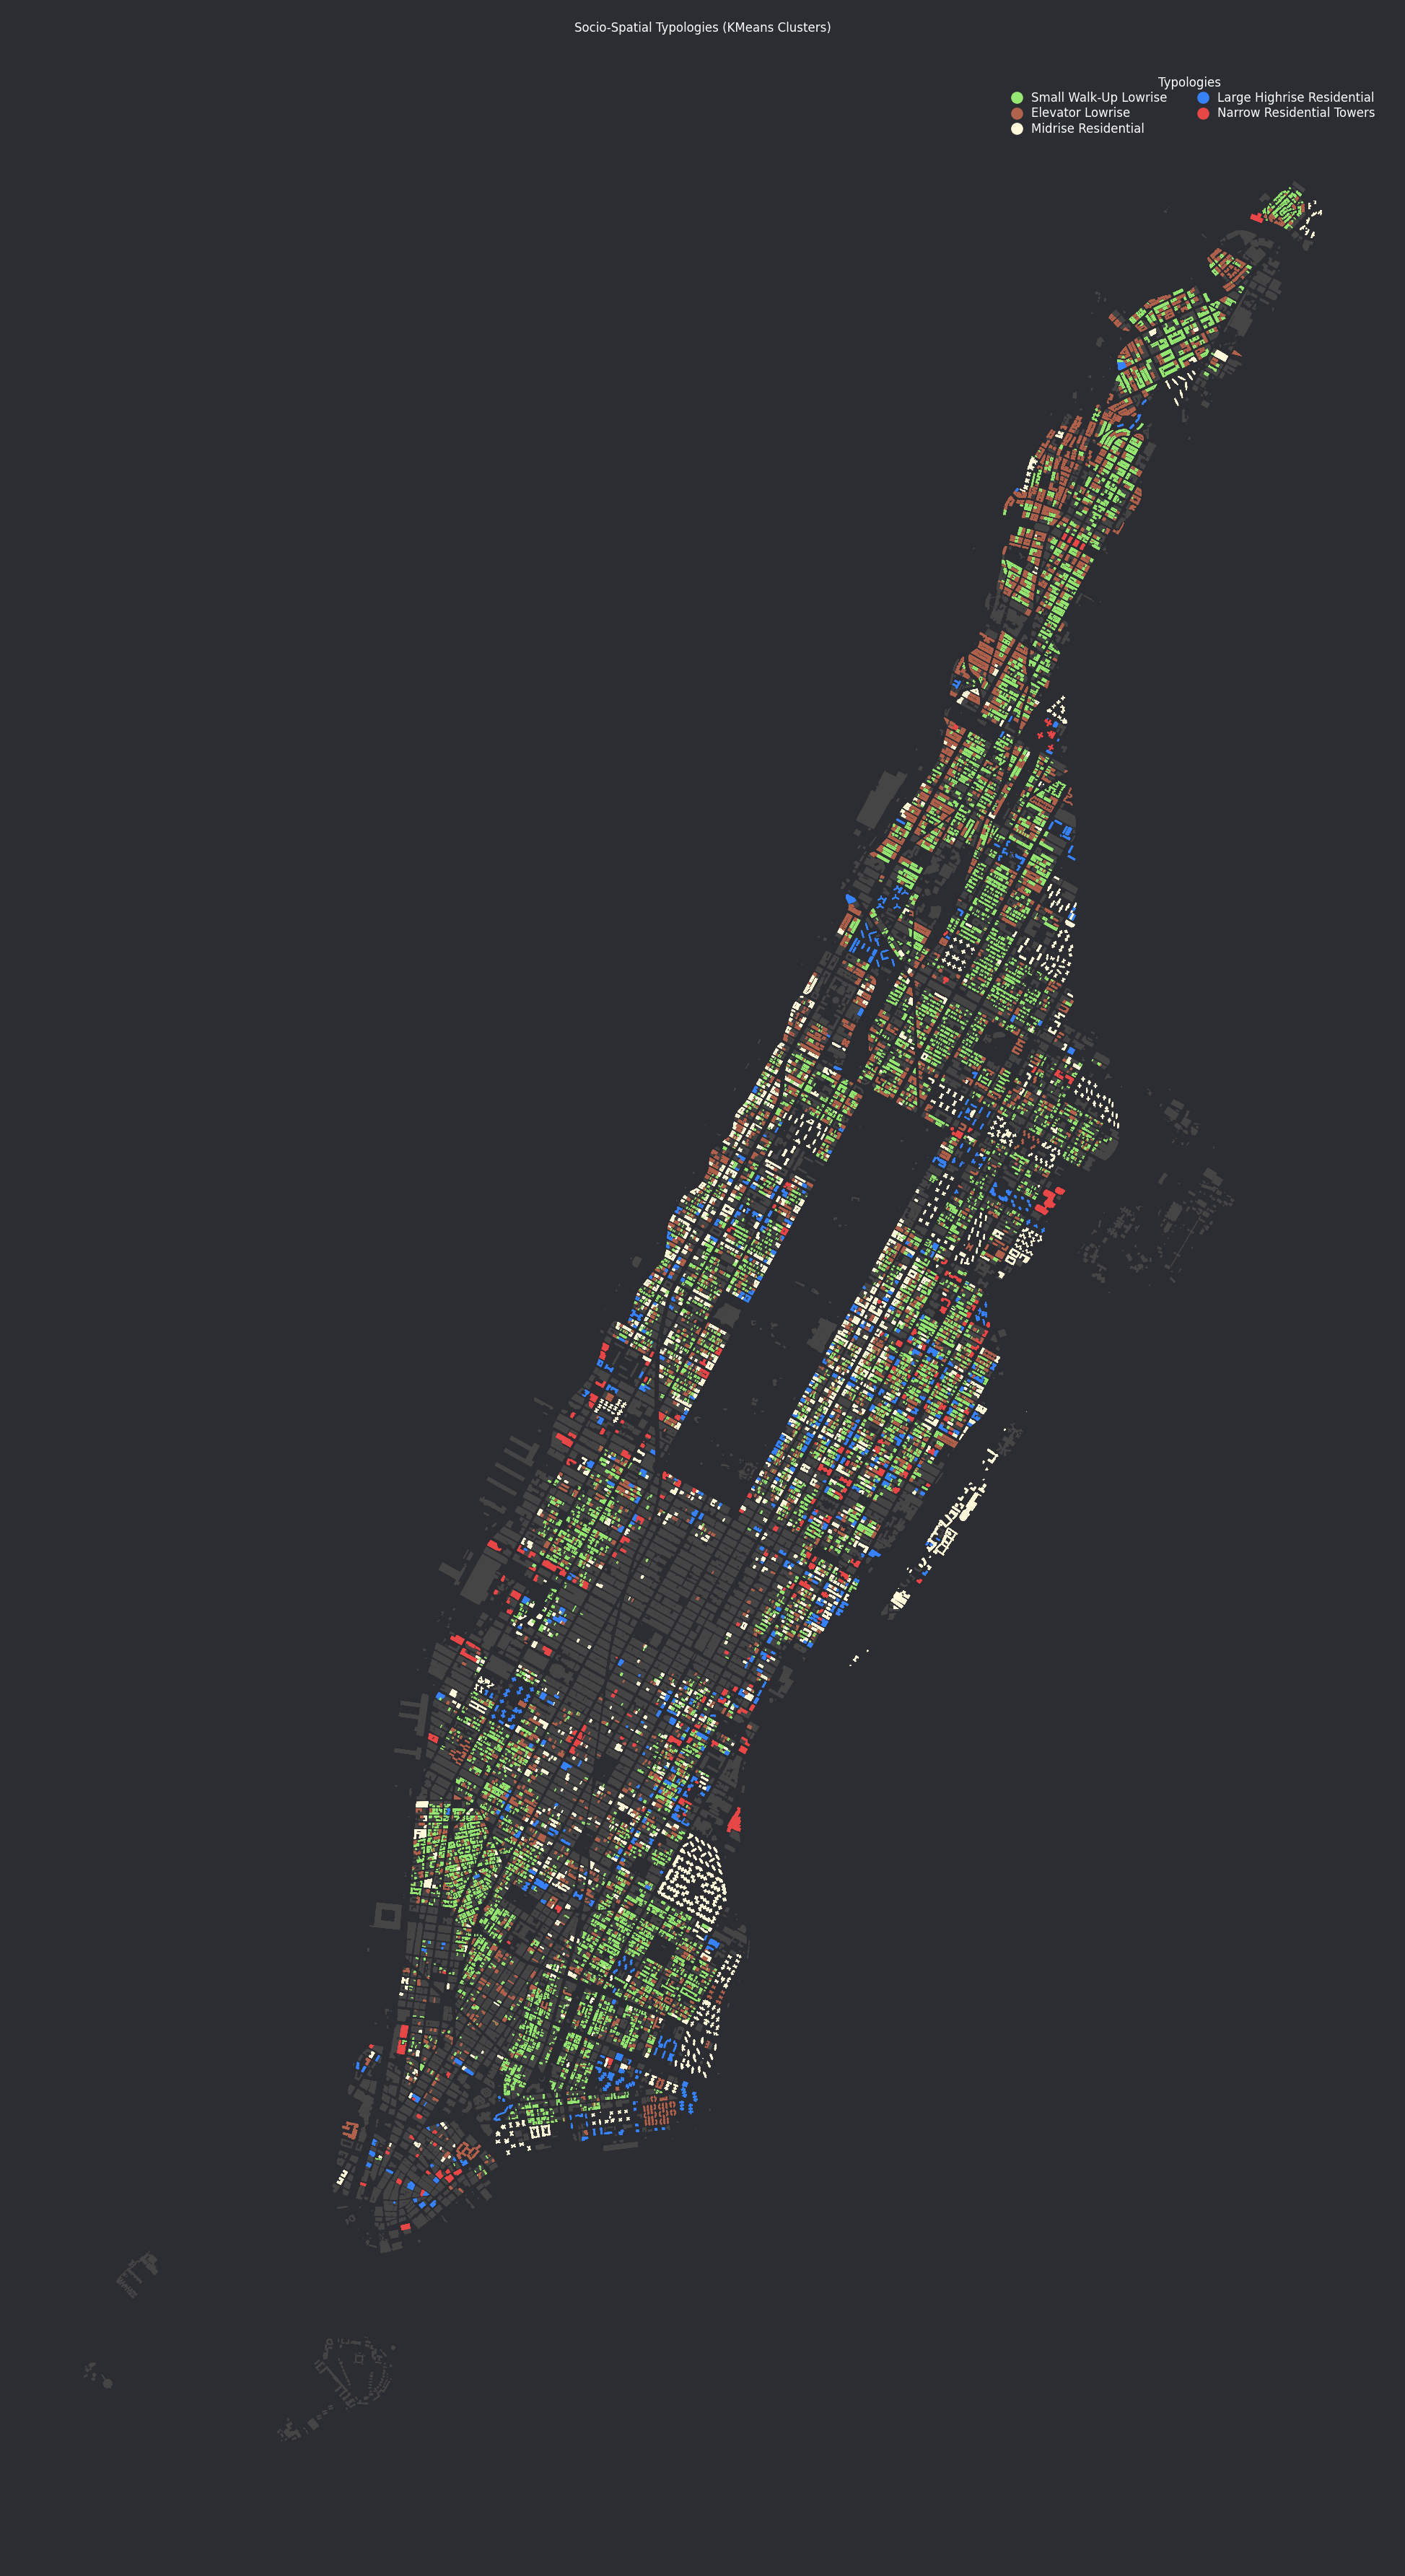

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pandas.api.types import CategoricalDtype

# --- base layers ---
nonres = manhattan[~manhattan['CURTAXCLASS'].isin([1, 2])]

# define the 6 cluster labels in order
cluster_labels = [
    "Small Walk-Up Lowrise",
    "Elevator Lowrise",
    "Midrise Residential",
    "Large Highrise Residential",
    "Narrow Residential Towers"
]

# mapping dictionary (0–5 → name)
cluster_names = dict(enumerate(cluster_labels))

# assign cluster names into your residential dataframe
# assumes you already have a column "kmeans_label" in res_socio
res_socio["bldg_cat_socio_spatial"] = res_socio["kmeans_label"].map(cluster_names)

# custom colors for the 6 clusters
custom_colors = {
    "Small Walk-Up Lowrise":                   "#97e773",
    "Elevator Lowrise":                        "#b1624c",
    "Midrise Residential":                     "#fff9db",
    "Large Highrise Residential":              "#3882F9",
    "Narrow Residential Towers":               "#e74747",
}

# enforce categorical order
cat_dtype = CategoricalDtype(categories=cluster_labels, ordered=True)
res_socio["bldg_cat_socio_spatial"] = res_socio["bldg_cat_socio_spatial"].astype(cat_dtype)

# colormap in the same order as cluster_labels
color_list = [custom_colors[c] for c in cluster_labels]
cmap = ListedColormap(color_list)

# ---- plot ----
fig, ax = plt.subplots(figsize=(10, 12), dpi=300, facecolor="#2B2D32")

# 1) BASE: non-residential in black
nonres.plot(ax=ax, color="#454545", linewidth=0, edgecolor="none")

# 2) RESIDENTIAL: 6 clusters
res_socio.plot(
    ax=ax,
    column="bldg_cat_socio_spatial",
    cmap=cmap,
    linewidth=0,
    edgecolor="none",
    legend=True,
    categorical=True,
    legend_kwds={
        "title": "Typologies",
        "fontsize": 4,
        "title_fontsize": 4,
        "ncol": 2,
        "markerscale": 0.4,
        "handletextpad": 0.2,
        "labelspacing": 0.2,
        "borderpad": 0.2,
        "frameon": False,
    },
)

ax.set_title("Socio-Spatial Typologies (KMeans Clusters)", color="white", fontsize=4, pad=12)
ax.set_axis_off()

leg = ax.get_legend()
if leg:
    for txt in leg.get_texts():
        txt.set_color("white")
    if leg.get_title() is not None:
        leg.get_title().set_color("white")

plt.tight_layout()
plt.show()


In [20]:
fig.savefig('architectural.png', dpi=300, transparent=True)
plt.close(fig)

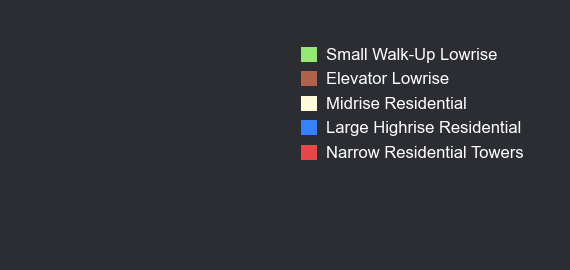

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

arial_font = FontProperties(family="Arial", size=4)
# Build legend handles directly from cluster_labels and custom_colors
handles = [
    mpatches.Patch(facecolor=custom_colors[label], edgecolor="none", label=label)
    for label in cluster_labels
]

# Create legend-only figure
fig, ax = plt.subplots(figsize=(2, 1), dpi=300, facecolor="#2B2D32")
ax.axis("off")

leg = ax.legend(
    handles=handles,
    fontsize=4,
    prop=arial_font,
    title_fontsize=4,
    ncol=1,
    markerscale=0.4,
    handletextpad=0.5,
    labelspacing=0.5,
    borderpad=0.5,
    frameon=False,
    handlelength=1.0,
    handleheight=1.0,
)

# Match text color to white (like in your map plot)
for txt in leg.get_texts():
    txt.set_color("white")
if leg.get_title() is not None:
    leg.get_title().set_color("white")

plt.tight_layout()
plt.show()


In [22]:
fig.savefig('architectural_legend.png', dpi=300, transparent=True)
plt.close(fig)